# Higgs Challenge Example using Neural Networks
In this part we will look at the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** on Kaggle and attempt a solution using neural networks (NN). The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**. More information about the data is available from the links, and in particular at **[Documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**. The general idea is that we want to extract $H\to\tau\tau$ signal from background. In particular, the selection requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. The challenge is based on Monte Carlo events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.


## Background on Neural Networks
(based on lectures from **[ML Course on Coursera](https://www.coursera.org/learn/machine-learning)**)

As we saw from the logistic regression yesterday, linear classifiers are often not the best at solving complicated problems. Neural networks introduce nonlinearity. They were originally designed to mimic the brain, and were popular in the 80s and early 90s. Recently they have become popular again, especially as deep neural networks DNNs, including convolutional NNs (CNN), recurrent NNs (RNN), etc. Those are beyond the scope of this class, but we will introduce the basics of NNs.

Below is a diagram of a simple NN:
![NNFig](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)
It is made up of "neurons" that get a number of inputs, processes them, and sends the output to other neurons. Mathematically, one can represent the a neuron's "activation" $a = g\left(\theta^Tx\right)$, where $x$ are the inputs (a vector), and $\theta$ are the parameters (weights) of the model (also a vector), and $g$ is the activation fuction. For example, if we use a logistic function as the activation function, we can have $g\left(\theta^Tx\right) = \frac{1}{1+\mathrm{exp}\left(-\theta^Tx\right)}$, or if a Rectified Linear Unit (ReLU), $g\left(\theta^Tx\right) = \mathrm{max}\left(0, \theta^Tx\right)$. The NN above has an input layer (layer 1), a hidden layer (layer 2), and an output layer (layer 3). One can have more hidden layers. Let's label the activations of layer 2 as $a_i^{(2)} = g\left(\theta_i^{(1)T}x\right)$, where $i$ is the index of the individual neurons. Note that the subscript of the $\theta$ is (1). That is because these are the weights going from layer 1 to 2. Putting together all the individual weight vectors together forms a matrix $\Theta^{(1)}$.

Using matrix notation, we can define $z^{(j)} = \Theta^{(j-1)}a^{(j-1)}$ and then $a^{(j)} = g(z^{(j)})$. Thus evaluating the NN is a series of matrix multiplications followed by activation functions.


The cost function of a NN is similar to what we have for logistic regression, modified to take into account possible multiple outputs, and with more complicated regularization. In order to train the NN, we have to determine the weight matrix $\Theta$ that minimizes the cost function. Backpropagation is the method used to do that. It calculates the partial derivatives "errors" for each $z_i^{(j)}$ by propagating the errors backwards. Usually something like (stochastic) gradient descent is used to solve the problem. For more details on backprorpagation, look, for example, at the **[ML course](https://www.coursera.org/learn/machine-learning)** mentioned above.

Now let's start trying to apply a NN to the Higgs Challenge data. We will start using Scikit Learn, and then try **[Keras](https://keras.io/)**.

In [1]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')

In [3]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


There is more information about the variables in the documentation. The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from backround. On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. They themselves generally do not provide much discrimination, but one if the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. *EventId* identifies the event but is not a "feature." The *Weight* is the event weight so that the sum of weights of all signal events should produce the signal yield expected to be observed in 2012, and the sum of weights of all background events should produce the backgroudn yield. Note that the weight varies event to event, because different background and signal processes contribute to the background and signal sets. *Label* indicates if it is a signal or background event. Ignore the *Kaggle* variables--they are only used if you want to reproduce exactly what was used in the Challenge. 

In [4]:
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1})


In [5]:
df.iloc[:5]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,0,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,0,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,0,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,0,t,6.245333


In [6]:
# let's create separate arrays
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [7]:
#now split into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

In [9]:
# now let's first look at a NN in sklearn
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(verbose=True)


In [10]:
# and train
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.98270141
Iteration 2, loss = 0.70650215
Iteration 3, loss = 0.64800695
Iteration 4, loss = 0.64291382
Iteration 5, loss = 0.59437137
Iteration 6, loss = 0.56616702
Iteration 7, loss = 0.54513114
Iteration 8, loss = 0.53357325
Iteration 9, loss = 0.50208177
Iteration 10, loss = 0.49216077
Iteration 11, loss = 0.48369652
Iteration 12, loss = 0.47536833
Iteration 13, loss = 0.46379574
Iteration 14, loss = 0.45551704
Iteration 15, loss = 0.44735322
Iteration 16, loss = 0.43738810
Iteration 17, loss = 0.43277851
Iteration 18, loss = 0.42866314
Iteration 19, loss = 0.42387502
Iteration 20, loss = 0.41924680
Iteration 21, loss = 0.41725630
Iteration 22, loss = 0.41229860
Iteration 23, loss = 0.41072650
Iteration 24, loss = 0.40875766
Iteration 25, loss = 0.40678001
Iteration 26, loss = 0.40414717
Iteration 27, loss = 0.40426950
Iteration 28, loss = 0.40120989
Iteration 29, loss = 0.40133914
Iteration 30, loss = 0.40021265
Iteration 31, loss = 0.39812609
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [11]:
mlp.score(X_test, y_test)

0.82248656576018719

The Kaggle competition used the approximate median segnificance (AMS), as defined below, to determine how good a solution was. The number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.

Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the toal yield, which we will do below.

In [12]:
# compute approximate median segnificance (AMS)

def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0

    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))


In [14]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob = mlp.predict_proba(X_train)[:, 1]
y_test_prob = mlp.predict_proba(X_test)[:, 1]
pcut = np.percentile(y_train_prob,85)


In [16]:
# add the probability to the original data frame
df['Prob']=mlp.predict_proba(X)[:, 1]


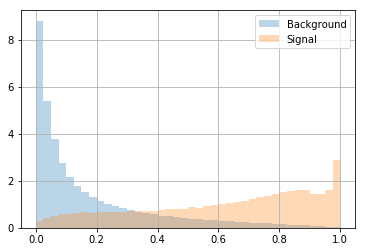

In [17]:
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

df[df.Label==0].Prob.hist(label='Background',**kwargs)
df[df.Label==1].Prob.hist(label='Signal',**kwargs)
plt.legend()


In [18]:
# Let's calculate the total weights (yields)
sigall = weight.dot(y)
backall = weight.dot(y == 0)

# The training weights
sigtrain = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

# The training weights
sigtest = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)

# aside:  these can also be done by looping instead of using a dot product
#  (Usually vectorized operations are faster for interpreted code)

In [19]:
# Now let's look at event yields that pass our selection
sigtrain_sel = weight_train.dot(np.multiply(y_train, y_train_prob > pcut))
backtrain_sel = weight_train.dot(np.multiply(y_train == 0, y_train_prob > pcut))

sigtest_sel = weight_test.dot(np.multiply(y_test, y_test_prob > pcut))
backtest_sel = weight_test.dot(np.multiply(y_test == 0, y_test_prob > pcut))


In [20]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_corr = sigtrain_sel*sigall/sigtrain
backtrain_sel_corr = backtrain_sel*backall/backtrain

sigtest_sel_corr = sigtest_sel*sigall/sigtest
backtest_sel_corr = backtest_sel*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_corr, ", background =",backtrain_sel_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_corr, ", background =",backtest_sel_corr)


Corrected selected yields in training sample, signal = 219.347205361 , background = 4750.45596371
Corrected selected yields in test sample, signal = 220.018857952 , background = 4931.57036877


In [21]:
print("AMS of training sample", ams(sigtrain_sel_corr,backtrain_sel_corr))
print("AMS of test sample", ams(sigtest_sel_corr,backtest_sel_corr))

AMS of training sample 3.1551696906404554
AMS of test sample 3.1070727666799316


How did we do? Worse than the BDT from yesterday.
![Comparison with submissions](data/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

Neural networks are quite sensitive to feature scaling, so let's try to scale the features.

In [26]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# and train a new network
mlp_scaled = MLPClassifier(verbose=True)
mlp_scaled.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.40210580
Iteration 2, loss = 0.37627343
Iteration 3, loss = 0.37072309
Iteration 4, loss = 0.36791575
Iteration 5, loss = 0.36648127
Iteration 6, loss = 0.36504797
Iteration 7, loss = 0.36432405
Iteration 8, loss = 0.36365296
Iteration 9, loss = 0.36313779
Iteration 10, loss = 0.36277819
Iteration 11, loss = 0.36238728
Iteration 12, loss = 0.36195794
Iteration 13, loss = 0.36172647
Iteration 14, loss = 0.36146493
Iteration 15, loss = 0.36118396
Iteration 16, loss = 0.36097046
Iteration 17, loss = 0.36067766
Iteration 18, loss = 0.36041217
Iteration 19, loss = 0.36034322
Iteration 20, loss = 0.36010304
Iteration 21, loss = 0.36000407
Iteration 22, loss = 0.35971477
Iteration 23, loss = 0.35965408
Iteration 24, loss = 0.35948312
Iteration 25, loss = 0.35929238
Iteration 26, loss = 0.35916584
Iteration 27, loss = 0.35916680
Iteration 28, loss = 0.35900119
Iteration 29, loss = 0.35886586
Iteration 30, loss = 0.35885280
Iteration 31, loss = 0.35868764
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [29]:
mlp_scaled.score(X_test_scaled, y_test)

0.83703369022179919

In [31]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_scaled = mlp_scaled.predict_proba(X_train_scaled)[:, 1]
y_test_prob_scaled = mlp_scaled.predict_proba(X_test_scaled)[:, 1]
pcut_scaled = np.percentile(y_train_prob_scaled,85)


In [32]:
# Now let's look at event yields that pass our selection
sigtrain_sel_scaled = weight_train.dot(np.multiply(y_train, y_train_prob_scaled > pcut_scaled))
backtrain_sel_scaled = weight_train.dot(np.multiply(y_train == 0, y_train_prob_scaled > pcut_scaled))

sigtest_sel_scaled = weight_test.dot(np.multiply(y_test, y_test_prob_scaled > pcut_scaled))
backtest_sel_scaled = weight_test.dot(np.multiply(y_test == 0, y_test_prob_scaled > pcut_scaled))


In [33]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_scaled_corr = sigtrain_sel_scaled*sigall/sigtrain
backtrain_sel_scaled_corr = backtrain_sel_scaled*backall/backtrain

sigtest_sel_scaled_corr = sigtest_sel_scaled*sigall/sigtest
backtest_sel_scaled_corr = backtest_sel_scaled*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_scaled_corr, ", background =",backtrain_sel_scaled_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_scaled_corr, ", background =",backtest_sel_scaled_corr)


Corrected selected yields in training sample, signal = 246.871516281 , background = 4967.47427104
Corrected selected yields in test sample, signal = 245.593074532 , background = 5273.15790218


In [34]:
print("AMS of training sample", ams(sigtrain_sel_scaled_corr,backtrain_sel_scaled_corr))
print("AMS of test sample", ams(sigtest_sel_scaled_corr,backtest_sel_scaled_corr))

AMS of training sample 3.4708381281557745
AMS of test sample 3.353169310835285


We improved somewhat.

SciKit Learn has simple NNs, but if you want to do deep NNs, or train on GPUs, you probalby want to use something like Keras instead. Let's try to create a simple NN using Keras.

In [44]:
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense


In [48]:
# create the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(30,)))
model.add(Dense(1, activation='sigmoid'))


In [49]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.fit(X_train_scaled, y_train, epochs=20, batch_size=128)

Epoch 1/20
548219/548219 [==============================] - 11s 20us/step - loss: 0.3655 - acc: 0.8364
Epoch 2/20
548219/548219 [==============================] - 11s 19us/step - loss: 0.3642 - acc: 0.8370
Epoch 3/20
548219/548219 [==============================] - 10s 19us/step - loss: 0.3632 - acc: 0.8372
Epoch 4/20
548219/548219 [==============================] - 12s 22us/step - loss: 0.3626 - acc: 0.8377
Epoch 5/20
548219/548219 [==============================] - 11s 20us/step - loss: 0.3619 - acc: 0.8381
Epoch 6/20
548219/548219 [==============================] - 11s 20us/step - loss: 0.3614 - acc: 0.8381
Epoch 7/20
548219/548219 [==============================] - 11s 20us/step - loss: 0.3612 - acc: 0.8385
Epoch 8/20
548219/548219 [==============================] - 10s 19us/step - loss: 0.3608 - acc: 0.8385
Epoch 9/20
548219/548219 [==============================] - 11s 20us/step - loss: 0.3604 - acc: 0.8387
Epoch 10/20
548219/548219 [==============================] - 10s 19us/ste

In [60]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 15%, but can optimize
y_train_prob_keras = model.predict(X_train_scaled)[:, 0]
y_test_prob_keras = model.predict(X_test_scaled)[:, 0]
pcut_keras = np.percentile(y_train_prob_keras,85)


In [61]:
# Now let's look at event yields that pass our selection
sigtrain_sel_keras = weight_train.dot(np.multiply(y_train, y_train_prob_keras > pcut_keras))
backtrain_sel_keras = weight_train.dot(np.multiply(y_train == 0, y_train_prob_keras > pcut_keras))

sigtest_sel_keras = weight_test.dot(np.multiply(y_test, y_test_prob_keras > pcut_keras))
backtest_sel_keras = weight_test.dot(np.multiply(y_test == 0, y_test_prob_keras > pcut_keras))


In [62]:
# Now we need to correct the selected yields to be is if we used the full sample
sigtrain_sel_keras_corr = sigtrain_sel_keras*sigall/sigtrain
backtrain_sel_keras_corr = backtrain_sel_keras*backall/backtrain

sigtest_sel_keras_corr = sigtest_sel_keras*sigall/sigtest
backtest_sel_keras_corr = backtest_sel_keras*backall/backtest

print("Corrected selected yields in training sample, signal =", sigtrain_sel_keras_corr, ", background =",backtrain_sel_keras_corr)
print("Corrected selected yields in test sample, signal =", sigtest_sel_keras_corr, ", background =",backtest_sel_keras_corr)


Corrected selected yields in training sample, signal = 233.499170452 , background = 4203.34711742
Corrected selected yields in test sample, signal = 231.313389116 , background = 4486.01490432


In [63]:
print("AMS of training sample", ams(sigtrain_sel_keras_corr,backtrain_sel_keras_corr))
print("AMS of test sample", ams(sigtest_sel_keras_corr,backtest_sel_keras_corr))

AMS of training sample 3.564777581616436
AMS of test sample 3.4207801822251915


We only made a single layer NN in Keras. However, you can easily change the structure of the network. As an assignment, try adding an extra hidden layer and changing the number of neurons.